DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions, findings, conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the Under Secretary of Defense for Research and Engineering.

© 2024 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part 252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed above. Use of this work other than as specifically authorized by the U.S. Government may violate any copyrights that exist in this work.


# Experimentation on generating fill-in-the-blank style responses to learn a set of conditional preferences over time.

This notebook demonstrates the behavior of the `SetChoicesBot` instantiations of `bot_interfaces.py` with a set of preferences defined by the `game_environment` choice below, included in this repository.

Imports and LLM setup.

In [1]:
# import langchain dependencies
from langchain.schema import HumanMessage

# import other dependencies
import matplotlib.pyplot as plt
import yaml
from datetime import datetime
import os
from typing import Type

from io_functions import *
from langchain_setup import *
from bot_interfaces import *

from preference_dungeon import *
from plotting import bots_mean_and_std


In [2]:
game_environment = "dungeons_and_dragons"        # what game environment? "food_offer", "dungeons_and_dragons", or "lamp4"
verbose_output = True                            # print more outputs
save_session = True                              # save LLM outputs as pickle       
offer_justification = True                       # should the bot offer a justification

MODEL_NAME = "gpt-4"
EMBEDDINGS = "text-embedding-ada-002"


Set variables given the above

In [3]:
llm = ChatOpenAI(model_name=MODEL_NAME)
embeddings = OpenAIEmbeddings(model=EMBEDDINGS)

# load yaml files
# these should be filled automatically, but will leave them as editable items just in case
prompts_yaml_path = os.path.join("prompt_templates", game_environment, "prompts.yaml")
game_environment_yaml_path = os.path.join(
    "prompt_templates", game_environment, "setting_and_cast.yaml"
)
game_preferences_yaml_path = os.path.join(
    "prompt_templates", game_environment, "preferences.yaml"
)

with open(prompts_yaml_path, "r", encoding="utf-8") as file:
    prompts_yaml = yaml.safe_load(file)
    initial_prompt = HumanMessage(content=prompts_yaml["initial_prompt"])
    encounter_template = prompts_yaml["encounter_template"]

    if offer_justification:
        langchain_offer_template = prompts_yaml[
            "langchain_offer_justification_template"
        ]
        response_template = prompts_yaml["response_justification_template"]
    else:
        langchain_offer_template = prompts_yaml["langchain_offer_template"]
        response_template = prompts_yaml["response_template"]

Load and check contexts and preferences. Contexts and preferences are specific to the closed-form version of how this is used. They determine the situations that an LLM is presented to evaluate and the limited set of preferences that constitute correct answers in those settings.

In [4]:
context_categories, offer_categories, preferences = check_and_load_yaml(
    game_environment_yaml_path, game_preferences_yaml_path
)

if verbose_output:
    print("\nContext Categories")
    for k, v in context_categories.items():
        print(k, v)
    print("\nOffer Categories")
    for k, v in offer_categories.items():
        print(k, v)
    print("\nPreferences")
    for k, v in preferences.items():
        print(k, v)

# create the "set choices" version of the DungeonMaster class
dm = DungeonMasterSetChoices(
    list(context_categories.values()),
    list(offer_categories.values()),
    encounter_template,
    response_template,
    preferences,
    seed=random.randint,
)


Context Categories
level [3, 5, 8]
alignment ['chaotic good', 'lawful evil', 'true neutral']
class ['wizard', 'warlock', 'sorcerer']
creature ['imp', 'troll', 'dragon', 'wraith']

Offer Categories
action ['run', 'cast alter self', 'cast chaos bolt', 'cast charm monster', 'cast chain lightning', 'cast earth tremor', 'cast fire bolt', 'cast gaseous form', 'cast grease', 'cast illusory dragon', 'cast minor illusion', 'cast mislead', 'cast shatter']

Preferences
run ['dragon', 'troll']
cast grease ['imp', 'troll']
cast illusory dragon ['sorcerer', 'wizard']
cast charm monster ['chaotic good']
cast gaseous form ['wraith']
cast mislead ['lawful evil']
cast minor illusion ['wraith']
All contexts can be satisfied by the given preferences.


Define evaluation loop and bots. 

A *bot* is just any variant of agent that we are testing (e.g. random, full-history context LLM, summary variants, RAG, etc). All bots need to match the Bot abstract class in `bot_interfaces.py` to work with the evaluation loop.

In [5]:
def evaluation_loop(
    dm: Type[DungeonMaster], bot_list: list[Type[Bot]], iterations: int = 1
):

    # create a list of dictionaries to hold the results
    bot_results = []
    encounters = []

    # set up the bot_results array, with one dictionary of results per bot in the list given as input
    for bot in bot_list:
        bot_results.append(
            {
                "bot name": bot.name,
                "contexts presented": 0,
                "valid offers": 0,
                "accepted offers": 0,
                "response history": [],
                "result history": [],
            }
        )

    # loop over encounters
    for encounter_num in range(1, iterations + 1):

        encounters.append(dm.print_current_context())  # append the current context
        if verbose_output:
            print(f"DM: Encounter {encounter_num}: {dm.print_current_context()}")

        # loop over bot list and have each bot evaluate the current context
        for i, bot in enumerate(bot_list):
            # the offer that the bot makes in this context
            offer_str = bot.make_offer(
                offer_categories, f"Context: {dm.print_current_context()}"
            )

            # the result of the offer
            offer_result_str = dm.evaluate_offer(offer_str, string_output=True)

            # the text of the full interaction (for printing and memory)
            full_interaction_str = (
                f"{dm.print_current_context()} {offer_str} {offer_result_str}"
            )
            print(f"{bot.name}: {offer_str} {offer_result_str}")

            # update the bot memory with what just happened
            # important! not all bots need to implement the update_memory function - what each bot does with memory is up to the bot_interface
            bot.update_memory(full_interaction_str)

            # check the offer result output
            assert offer_result_str in [
                "ACCEPTED",
                "REJECTED",
                "INVALID OFFER",
            ], f"{offer_result_str=}"

            # tally up results
            bot_results[i]["contexts presented"] += 1
            bot_results[i]["response history"].append(offer_str)
            bot_results[i]["result history"].append(offer_result_str)
            if offer_result_str == "ACCEPTED":
                bot_results[i]["valid offers"] += 1
                bot_results[i]["accepted offers"] += 1
            elif offer_result_str == "REJECTED":
                bot_results[i]["valid offers"] += 1

        # advance the context (context is kept the same while we're looping through bots)
        dm.next_context()
        print("---")

    return encounters, bot_results

In [6]:
# make the list of bots to be evaluated
bot_list = [
    RandomBot(response_template),
    LLMWithEntireHistoryBot(llm, initial_prompt.content, langchain_offer_template),
    LLMWithPeriodicSummaryBot(
        llm, initial_prompt.content, langchain_offer_template, 10
    ),
]

# run the evaluation loop
encounters, bot_results = evaluation_loop(dm, bot_list, iterations=2)

DM: Encounter 1: The player, a level 3 true neutral wizard, encounters a imp.
RandomBot: The player should cast chaos bolt because I chose randomly. REJECTED
LLMWithEntireHistoryBot: The player should cast earth tremor because it can cause the imp to lose its balance and become prone, making it easier to attack. REJECTED
LLMWithPeriodicSummaryBot: The player should cast fire bolt because it is a simple yet effective offensive spell that can deal with lower level creatures like imps. REJECTED
---
DM: Encounter 2: The player, a level 8 true neutral warlock, encounters a troll.
RandomBot: The player should cast grease because I chose randomly. ACCEPTED
LLMWithEntireHistoryBot: The player should cast fire bolt because trolls are vulnerable to fire damage. REJECTED
LLMWithPeriodicSummaryBot: The player should cast fire bolt because trolls are weak to fire damage. REJECTED
---


In [7]:
if save_session:
    dump_session_variables(
        game_environment
        + "_"
        + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        + "_evaluation_run.pkl",
        [dm, encounters, bot_results],
        ["dm", "encounters", "bot_results"],
    )

saving dm
saving encounters
saving bot_results


Plot results

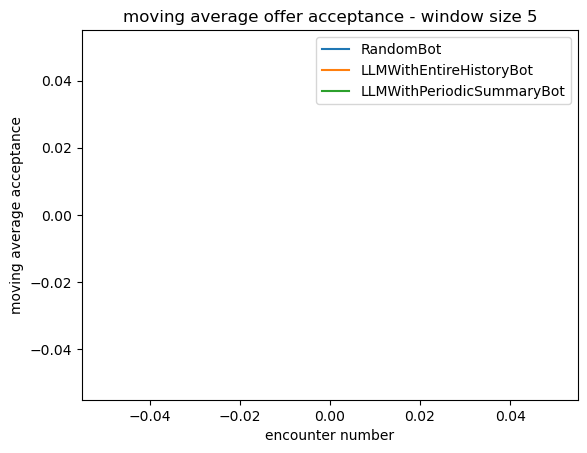

In [8]:
moving_window_size = 5

plt.figure()
results_by_bot = bots_mean_and_std(bot_results, moving_window_size)
x_vals = range(moving_window_size, len(dm.context_history) + 1)
for bot_name in results_by_bot.keys():
    plt.plot(x_vals, results_by_bot[bot_name][0])
    plt.fill_between(
        x_vals,
        results_by_bot[bot_name][0] - results_by_bot[bot_name][1],
        results_by_bot[bot_name][0] + results_by_bot[bot_name][1],
        alpha=0.2,
        label="_nolegend_",
    )  # option to suppress the legend for the error regions
plt.xlabel("encounter number")
plt.ylabel("moving average acceptance")
plt.title(f"moving average offer acceptance - window size {moving_window_size}")
plt.legend([bot.name for bot in bot_list])